In [1]:
import sys
sys.path.append("..")
from ocr_ensemble.data import load_dataset_1K, load_dataset_10K, load_dataset_10K_large, load_dataset
from matplotlib import pyplot as plt
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
from ocr_ensemble import OCR
from sklearn.linear_model import LogisticRegression
import clip
import torch
import torchvision.transforms as T
import pickle
from einops import rearrange
from ocr_ensemble.proposers import xywh2uull
from paddleocr import draw_ocr
from PIL import Image
import cv2

In [2]:
def identity(x):
    return x


device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
transform = T.ToPILImage()


clip_preproc = T.Lambda(lambda img: preprocess(transform(rearrange(torch.tensor(img), 'a b c -> c a b'))))

parquet_fname = '../data/laion2b-en-10K.parquet'
dataset_path = '../data/laion2b-en-10K'
dataset = load_dataset(dataset_path, parquet_fname)
dataset2 = dataset.map_tuple(clip_preproc, identity, identity)
loader = torch.utils.data.DataLoader(dataset2, batch_size=50)

with open('../models/presence_clf.pkl', 'rb') as f:
    presence_clf = pickle.load(f)

In [3]:
features = []
labels = []
label_dict = {}
for imgs, captions, keys in tqdm(loader):
    feats = model.encode_image(imgs.to(device))
    caption_feats = model.encode_text(clip.tokenize([c[:77] for c in captions]).to(device))
    features += [feats.cpu().detach()]
    preds = presence_clf.predict(feats.cpu().detach())
    labels += [preds]
    for key, pred in zip(keys, preds):
        label_dict[key] = pred
    
features = torch.cat(features, axis=0)
labels = np.concatenate(labels, axis=0)


159it [00:51,  3.06it/s]


In [4]:
ocr = OCR()
dataset = load_dataset(dataset_path, parquet_fname) # needs to be done because the map_tuple above had side effects

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0it [00:00, ?it/s]

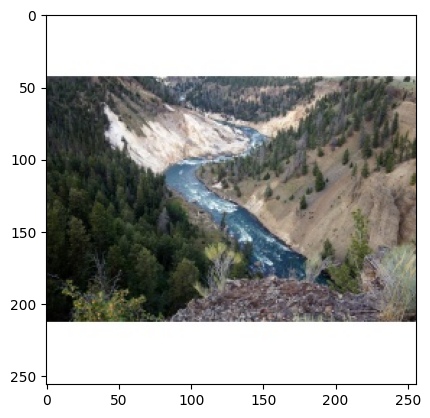

classifier detected no text


0it [00:00, ?it/s]


In [7]:
for img, caption, key in tqdm(dataset):
    plt.imshow(img)
    plt.show()
    if label_dict[key] == 1:
        image = (255*img).astype(np.uint8)
        bboxes, txts = ocr(image)
        im_show = draw_ocr(image, bboxes, txts, [1]*len(txts), font_path='../fonts/simfang.ttf')
        im_show = Image.fromarray(im_show)
        plt.imshow(im_show)
        plt.show()
    else:
        print('classifier detected no text')
    